# ML on ESDC using scikit-learn 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library scikit-learn. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with scikit-learn installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/).**

### Import necessary libraries

In [1]:
import math
import numpy as np
import pandas as pd
import mlflow
import xarray as xr
import dask.array as da
from xcube.core.store import new_data_store

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

from sklearn import metrics

from global_land_mask import globe
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
# use only lst and at
ds = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [3]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0 = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [4]:
lm = da.stack([lm0 for i in range(ds.dims['time'])], axis = 0)
lm

dask.array<stack, shape=(1840, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [5]:
xdsm = ds.assign(land_mask= (['time','lat','lon'],lm.rechunk(chunks=([v for k,v in ml.get_chunk_sizes(ds)]))))
xdsm

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube into a pandas dataframe.

In [6]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

land_surface_temperature  air_temperature_2m  \
lat        lon                                                         
 89.958333 -179.958333                       NaN          266.297180   
           -179.875000                       NaN          266.297180   
           -179.791667                       NaN          266.297180   
           -179.708333                       NaN          266.297180   
           -179.625000                       NaN          266.297180   
...                                          ...                 ...   
-89.958333  179.625000                       NaN          219.817398   
            179.708333                       NaN          219.817398   
            179.791667                       NaN          219.817398   
            179.875000                       NaN          219.817398   
            179.958333                       NaN          219.817398   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

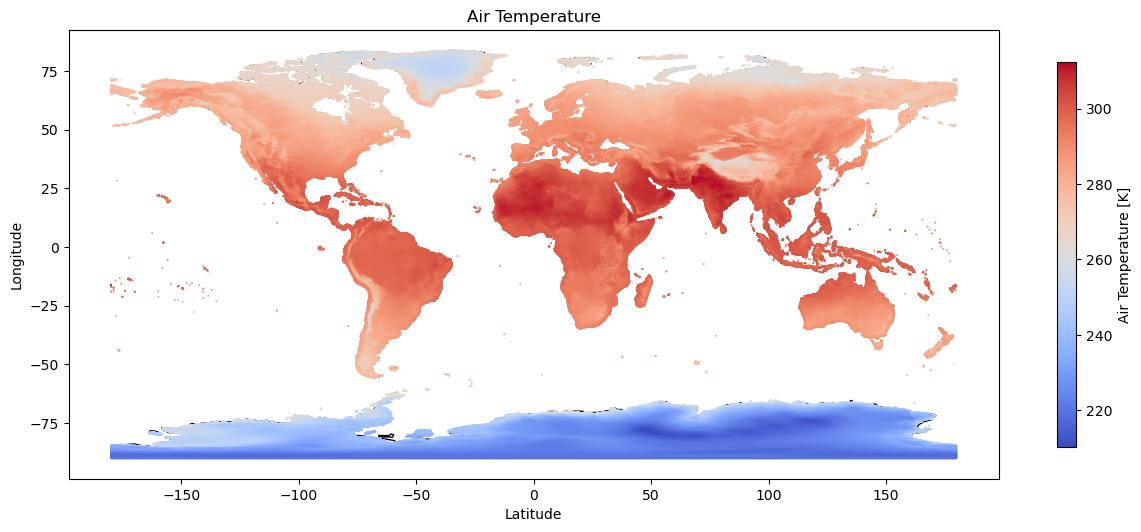

In [7]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'air_temperature_2m', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Air Temperature [K]'})

plt.title('Air Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('air_temp_masked.png')

Land Surface Temperature

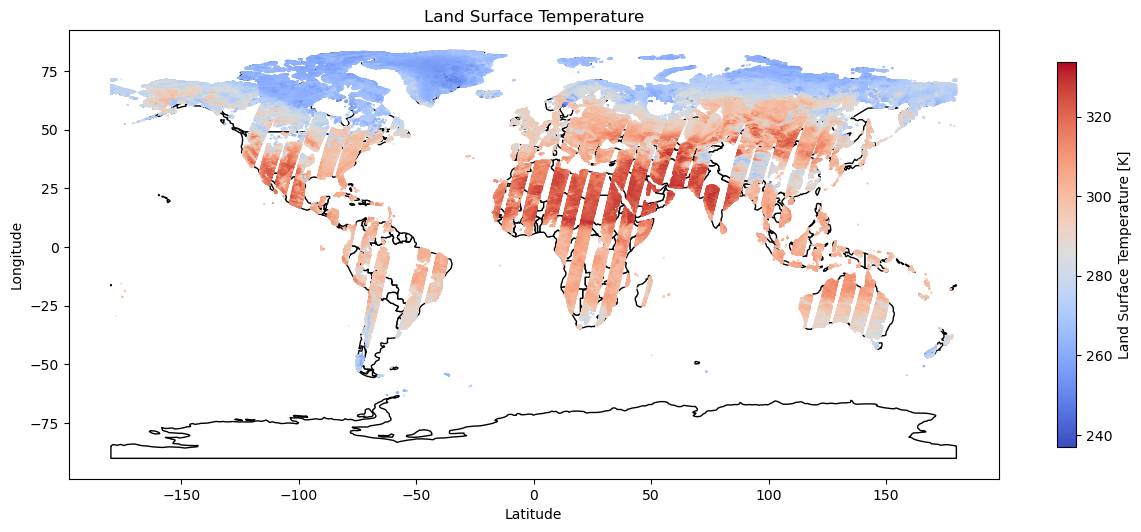

In [8]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'})

plt.title('Land Surface Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('land_surface_temperature.png')

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [9]:
from mltools.data_assignment import rand

# random sampling
xds = xdsm.assign({"split": rand})

# block sampling
# xds = ml.assign_block_split(xdsm, block_size=[("time", 10), ("lat", 100), ("lon", 100)], split=0.8)
xds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) bool dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

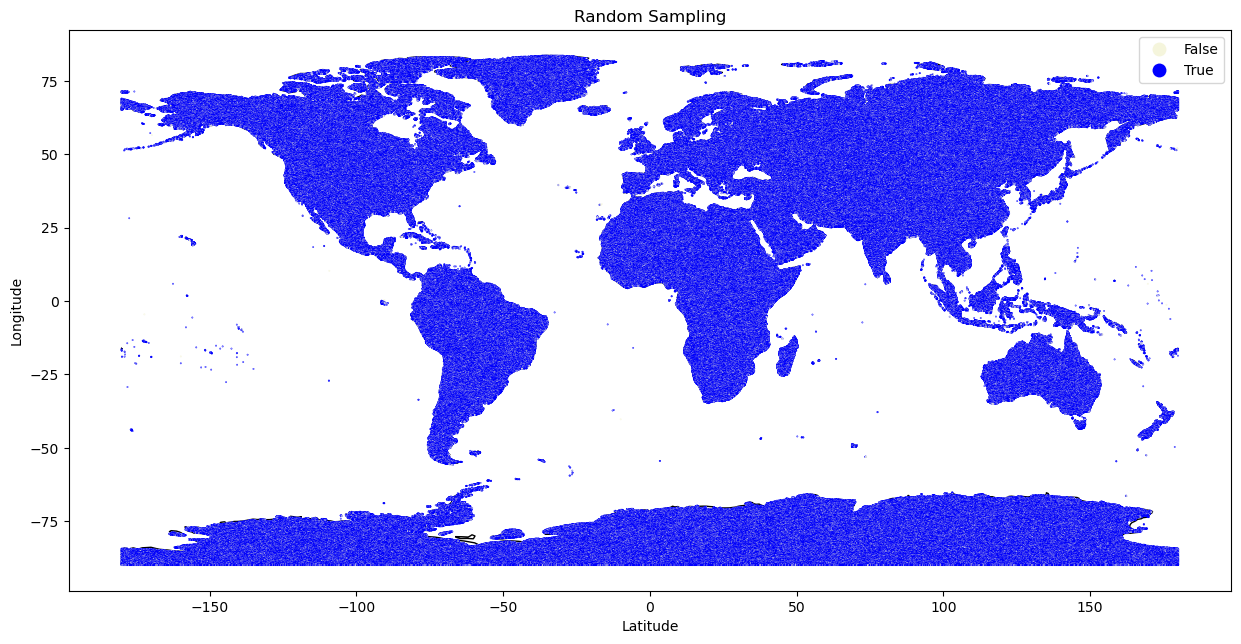

In [10]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'split', cmap = LinearSegmentedColormap.from_list("", ["beige","blue"]), legend = True)

plt.title('Random Sampling')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.savefig('train_test_assignment_rnd.png')

## Model set up

In [11]:
sgdreg = SGDRegressor(warm_start = True)

#### Initialize MLFlow experiment

In [12]:
experiment_name = "Sklearn Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id = current_experiment['experiment_id']

run_name = "ESDC_LR_rnd"
mlflow.sklearn.autolog()

2024/01/23 09:11:17 INFO mlflow.tracking.fluent: Experiment with name 'Sklearn Linear Regression of LST from AT with mlflow' does not exist. Creating a new experiment.
2024/01/23 09:11:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [ ]:
from mltools.data_processing import get_range, get_statistics

at_range = get_range(ds, 'air_temperature_2m')
lst_range = get_range(ds, 'land_surface_temperature')

#at_stat = get_statistics(ds, 'air_temperature_2m')
#lst_stat = get_statistics(ds, 'land_surface_temperature')

### Train model
We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [ ]:
from mltools.cube_utilities import iter_data_var_blocks
from mltools.data_processing import normalize

with mlflow.start_run(experiment_id=experiment_id, run_name = run_name) as run:
    for chunk in iter_data_var_blocks(xds): 
        ### preprocessing
        cf = {x: chunk[x].ravel() for x in chunk.keys()}
        lm = cf['land_mask']
        cft = {x: cf[x][lm == True] for x in cf.keys()}
        lst = cft['land_surface_temperature']
        cfn = {x: cft[x][~np.isnan(lst)] for x in cft.keys()}
        if len(cfn['land_surface_temperature']) > 0:
            X = normalize(cfn['air_temperature_2m'], *at_range)
            y = normalize(cfn['land_surface_temperature'], *lst_range)
            
            ### get train/test data 
            X_train = X[cfn['split']==True]
            X_test  = X[cfn['split']==False]
            y_train = y[cfn['split']==True]
            y_test  = y[cfn['split']==False]
            ### train model
            if len(X_train) > 0:
                sgdreg.fit(X_train.reshape(-1, 1), y_train)

                y_pred_train = sgdreg.predict(X_train.reshape(-1, 1))
                mse_train = metrics.mean_squared_error(y_train, y_pred_train)
                mlflow.log_metric('train_loss', mse_train)
                print(f"Training Error: {mse_train:>8f}")
                
                if len(X_test) > 0:
                    y_pred_test = sgdreg.predict(X_test.reshape(-1, 1))
                    mse_test  = metrics.mean_squared_error(y_test, y_pred_test)
                    mlflow.log_metric('train_loss', mse_test)
                    print(f"Test Error: {mse_test:>8f}\n")

### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [ ]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

Predict missing Land Surface Temperature values from Air Temperature values

In [ ]:
from mltools.data_processing import normalize, undo_normalizing

dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = normalize(to_pred['air_temperature_2m'], *at_range)
X = X.values

lstp = sgdreg.predict(X.reshape(-1, 1))
output['land_surface_temperature'] = undo_normalizing(lstp, *lst_range)
output

### Plot Predictions

In [ ]:
df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

geometry = [Point(xy) for xy in zip(lst['lon'], lst['lat'])]
gdf = GeoDataFrame(lst, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'land_surface_temperature', cmap = 'coolwarm', vmin = 195, vmax = 335, legend = True, 
    legend_kwds={"shrink":.5, 'label': 'Land Surface Temperature [K]'})

plt.title('Landsurface Temperature')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#fname = 'xxx' +'.png'
#plt.savefig(fname)
plt.show()